C:\Users\KyleOvenell\AppData\Local\Temp\ipykernel_6524\4067259429.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_daily = yf.download(TICKER, start='2019-01-01', interval='1d', progress=False)


Total weeks: 357
Range: 2019-01-04 to 2025-10-31

Last few rows:
Price             Open        High         Low       Close    Volume
Date                                                                
2025-10-03  292.500000  294.350006  285.029999  291.309998  10814100
2025-10-10  291.500000  293.510010  284.649994  285.190002   8322500
2025-10-17  285.209991  287.690002  279.420013  281.269989   7704800
2025-10-24  281.609985  287.399994  280.660004  280.940002   6979000
2025-10-31  280.970001  282.929993  258.190002  260.299988  13026900
STEP 1: CURRENT 10-WEEK SEQUENCE
Pattern: 0-10-D
Up Weeks: 0
Down Weeks: 10
Trajectory: D (slope: -3.3692)
Entry Price: $260.30
Period: 2025-08-29 to 2025-10-31
STEP 2: HISTORICAL PATTERN OCCURRENCES
Current Pattern: 0-10-D
Total Historical Windows: 348
Matching Patterns: 2
Frequency: 0.57%
Rarity: Rare

Sample matches:
    start_date   end_date  pattern_end_price
346 2025-08-22 2025-10-24         280.940002
347 2025-08-29 2025-10-31         260.29

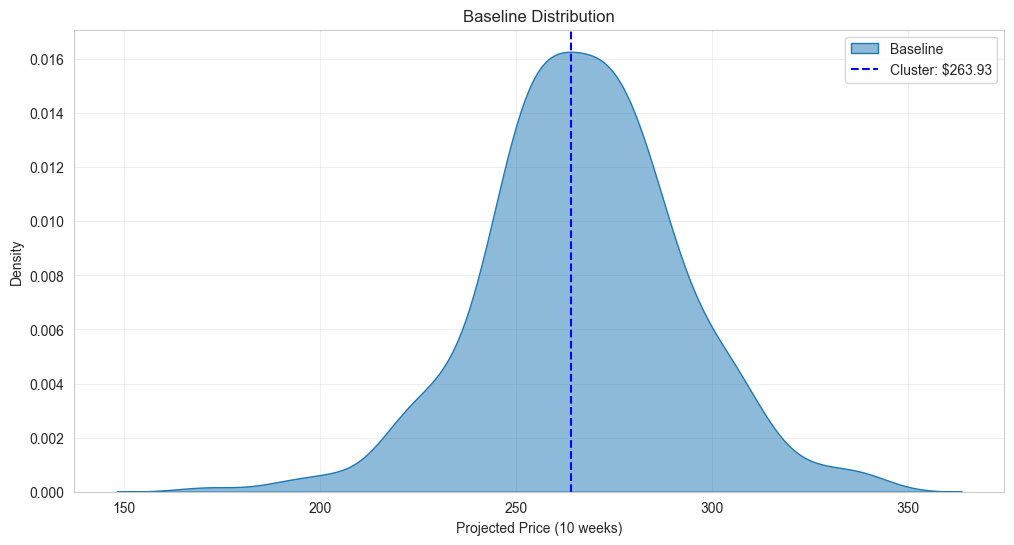


⚠️  Insufficient pattern data for strategy recommendation


In [112]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import linregress, gaussian_kde
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

TICKER = 'ADP'

print(f"Downloading daily data for {TICKER} from January 1, 2019...")
data_daily = yf.download(TICKER, start='2019-01-01', interval='1d', progress=False)

if isinstance(data_daily.columns, pd.MultiIndex):
    data_daily.columns = data_daily.columns.droplevel(1)

# Resample to weekly, ending on Fridays
data = data_daily.resample('W-FRI').agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'Volume': 'sum'
}).dropna()

print(f"Total weeks: {len(data)}")
print(f"Range: {data.index[0].date()} to {data.index[-1].date()}")
print(f"\nLast few rows:")
print(data.tail())
"""
Analyze most recent 10 weeks to generate X-Y-D/U pattern notation.
"""

current_window = data.tail(10).copy()

# Count up/down weeks (Close vs prior Close)
current_window['Up'] = (current_window['Close'] > current_window['Close'].shift(1)).astype(int)
up_weeks = current_window['Up'].sum()
down_weeks = 10 - up_weeks

# Calculate trajectory
close_prices = current_window['Close'].values.flatten()
weeks_index = np.arange(len(close_prices))
slope, intercept, r_value, p_value, std_err = linregress(weeks_index, close_prices)
trajectory = 'U' if slope > 0 else 'D'

# Entry price = closing price at END of pattern
entry_price = float(current_window.iloc[-1]['Close'].iloc[0] if hasattr(current_window.iloc[-1]['Close'], 'iloc') else current_window.iloc[-1]['Close'])

current_pattern = f"{up_weeks}-{down_weeks}-{trajectory}"

print("=" * 60)
print("STEP 1: CURRENT 10-WEEK SEQUENCE")
print("=" * 60)
print(f"Pattern: {current_pattern}")
print(f"Up Weeks: {up_weeks}")
print(f"Down Weeks: {down_weeks}")
print(f"Trajectory: {trajectory} (slope: {slope:.4f})")
print(f"Entry Price: ${entry_price:.2f}")
print(f"Period: {current_window.index[0].date()} to {current_window.index[-1].date()}")
"""
Scan historical data for matching pattern instances.
"""

def calculate_pattern(window_df):
    if len(window_df) < 10:
        return None
    up = (window_df['Close'] > window_df['Close'].shift(1)).sum()
    down = 10 - up
    closes = window_df['Close'].values.flatten()
    idx = np.arange(len(closes))
    slope, _, _, _, _ = linregress(idx, closes)
    traj = 'U' if slope > 0 else 'D'
    return f"{up}-{down}-{traj}"

patterns_list = []

for i in range(len(data) - 9):
    window = data.iloc[i:i+10]
    pattern = calculate_pattern(window)
    if pattern:
        pattern_end_price = float(window.iloc[-1]['Close'].iloc[0] if hasattr(window.iloc[-1]['Close'], 'iloc') else window.iloc[-1]['Close'])
        patterns_list.append({
            'pattern': pattern,
            'start_date': window.index[0],
            'end_date': window.index[-1],
            'pattern_end_price': pattern_end_price,
            'window_idx': i
        })

patterns_df = pd.DataFrame(patterns_list)
matches = patterns_df[patterns_df['pattern'] == current_pattern]
total_patterns = len(patterns_df)
match_count = len(matches)
frequency = (match_count / total_patterns) * 100 if total_patterns > 0 else 0

print("=" * 60)
print("STEP 2: HISTORICAL PATTERN OCCURRENCES")
print("=" * 60)
print(f"Current Pattern: {current_pattern}")
print(f"Total Historical Windows: {total_patterns}")
print(f"Matching Patterns: {match_count}")
print(f"Frequency: {frequency:.2f}%")
print(f"Rarity: {'Common' if frequency > 5 else 'Moderate' if frequency > 2 else 'Rare'}")

if match_count > 0:
    print(f"\nSample matches:")
    print(matches[['start_date', 'end_date', 'pattern_end_price']].head(10))
else:
    print(f"\n⚠️  No matches found - analysis will use baseline only")
"""
Calculate baseline distribution across all historical patterns.
"""

FORWARD_WEEKS = 10  # Adjusted to match Barchart's typical horizon

baseline_outcomes = []

for idx, row in patterns_df.iterrows():
    window_end_idx = row['window_idx'] + 9
    forward_idx = window_end_idx + FORWARD_WEEKS

    if forward_idx < len(data):
        pattern_end_price = data.iloc[window_end_idx]['Close']
        future_price = data.iloc[forward_idx]['Close']
        pct_change = ((future_price - pattern_end_price) / pattern_end_price) * 100
        baseline_outcomes.append({'pct_change': pct_change})

baseline_df = pd.DataFrame(baseline_outcomes)
baseline_projected = entry_price * (1 + baseline_df['pct_change'] / 100)

baseline_mean = baseline_projected.mean()
baseline_median = baseline_projected.median()

kde_baseline = gaussian_kde(baseline_projected.dropna())
x_range = np.linspace(baseline_projected.min(), baseline_projected.max(), 1000)
kde_values = kde_baseline(x_range)
baseline_cluster_price = x_range[np.argmax(kde_values)]

print("=" * 60)
print("STEP 3: BASELINE EXPECTATIONS")
print("=" * 60)
print(f"Sample Size: {len(baseline_df)}")
print(f"Forward Period: {FORWARD_WEEKS} weeks")
print(f"Entry Price: ${entry_price:.2f}")
print(f"\nBaseline Statistics:")
print(f"  Mean: ${baseline_mean:.2f}")
print(f"  Median: ${baseline_median:.2f}")
print(f"  Clustering: ${baseline_cluster_price:.2f}")

plt.figure(figsize=(12, 6))
sns.kdeplot(data=baseline_projected, fill=True, label='Baseline', alpha=0.5)
plt.axvline(baseline_cluster_price, color='blue', linestyle='--',
            label=f'Cluster: ${baseline_cluster_price:.2f}')
plt.xlabel(f'Projected Price ({FORWARD_WEEKS} weeks)')
plt.ylabel('Density')
plt.title('Baseline Distribution')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
# Cell 5: Step 4 - Calculate Sequence-Specific Distribution with GMM

from sklearn.mixture import GaussianMixture

pattern_outcomes = []

for idx, row in matches.iterrows():
    window_end_idx = row['window_idx'] + 9
    forward_idx = window_end_idx + FORWARD_WEEKS

    if forward_idx < len(data):
        pattern_end_price = data.iloc[window_end_idx]['Close']
        future_price = data.iloc[forward_idx]['Close']
        pct_change = ((future_price - pattern_end_price) / pattern_end_price) * 100
        pattern_outcomes.append({'pct_change': pct_change})

pattern_df = pd.DataFrame(pattern_outcomes)

if len(pattern_df) > 0:
    pattern_projected = entry_price * (1 + pattern_df['pct_change'] / 100)

    pattern_mean = pattern_projected.mean()
    pattern_median = pattern_projected.median()

    # GMM CLUSTERING - key addition
    X_pattern = pattern_projected.values.reshape(-1, 1)

    # Try 1-3 components, select best by BIC
    best_gmm = None
    best_bic = np.inf
    for n_components in range(1, 4):
        gmm = GaussianMixture(n_components=n_components, random_state=42)
        gmm.fit(X_pattern)
        bic = gmm.bic(X_pattern)
        if bic < best_bic:
            best_bic = bic
            best_gmm = gmm

    # Find dominant cluster (highest weight)
    dominant_idx = np.argmax(best_gmm.weights_)
    pattern_cluster_price = best_gmm.means_[dominant_idx][0]

    # Also calculate baseline with GMM
    X_baseline = baseline_projected.values.reshape(-1, 1)
    best_gmm_baseline = None
    best_bic_baseline = np.inf
    for n_components in range(1, 4):
        gmm = GaussianMixture(n_components=n_components, random_state=42)
        gmm.fit(X_baseline)
        bic = gmm.bic(X_baseline)
        if bic < best_bic_baseline:
            best_bic_baseline = bic
            best_gmm_baseline = gmm

    dominant_idx_baseline = np.argmax(best_gmm_baseline.weights_)
    baseline_cluster_price = best_gmm_baseline.means_[dominant_idx_baseline][0]

    print("=" * 60)
    print("STEP 4: SEQUENCE-SPECIFIC DISTRIBUTION")
    print("=" * 60)
    print(f"Pattern: {current_pattern}")
    print(f"Sample Size: {len(pattern_df)}")
    print(f"GMM Components: {best_gmm.n_components}")
    print(f"\nPattern Statistics:")
    print(f"  Mean: ${pattern_mean:.2f}")
    print(f"  Median: ${pattern_median:.2f}")
    print(f"  Clustering (GMM): ${pattern_cluster_price:.2f}")

    # Enhanced visualization with GMM
    plt.figure(figsize=(14, 7))
    sns.kdeplot(data=baseline_projected, fill=True, label='Baseline', alpha=0.3, color='blue')
    sns.kdeplot(data=pattern_projected, fill=True, label=f'Pattern ({current_pattern})',
                alpha=0.5, color='red')
    plt.axvline(baseline_cluster_price, color='blue', linestyle='--',
                label=f'Baseline GMM: ${baseline_cluster_price:.2f}')
    plt.axvline(pattern_cluster_price, color='red', linestyle='--',
                label=f'Pattern GMM: ${pattern_cluster_price:.2f}')

    # Plot GMM means
    for i, mean in enumerate(best_gmm.means_):
        plt.axvline(mean[0], color='red', linestyle=':', alpha=0.5)

    plt.xlabel(f'Projected Price ({FORWARD_WEEKS} weeks)')
    plt.ylabel('Density')
    plt.title(f'Distribution Comparison - {current_pattern} (GMM Clustering)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
"""
Calculate delta and exceedance metrics.
"""

if len(pattern_df) > 0:
    delta_pct = ((pattern_cluster_price - baseline_cluster_price) / baseline_cluster_price) * 100

    # FIX: Exceedance should measure if historical future prices exceeded their respective anchors
    # This is equivalent to checking if pct_change > 0
    exceedance_count = (pattern_df['pct_change'] > 0).sum()
    exceedance_ratio = (exceedance_count / len(pattern_df)) * 100

    terminal_median_price = pattern_median

    print("=" * 60)
    print("STEP 5: DELTA IN PRICE DENSITY DYNAMICS")
    print("=" * 60)
    print(f"Baseline Cluster: ${baseline_cluster_price:.2f}")
    print(f"Pattern Cluster: ${pattern_cluster_price:.2f}")
    print(f"Delta: {delta_pct:+.2f}%")
    print(f"Signal: {'BULLISH - Positive delta' if delta_pct > 0 else 'BEARISH - Negative delta'}")

    print("\n" + "=" * 60)
    print("STEP 6: SUPPORTING METRICS")
    print("=" * 60)
    print(f"Entry Price: ${entry_price:.2f}")
    print(f"Exceedance Ratio: {exceedance_ratio:.1f}%")
    print(f"Terminal Median: ${terminal_median_price:.2f}")
    print(f"Sample Size: {len(pattern_df)} instances")

    METRICS = {
        'delta_pct': delta_pct,
        'exceedance_ratio': exceedance_ratio,
        'pattern_cluster_price': pattern_cluster_price,
        'terminal_median_price': terminal_median_price,
        'baseline_cluster_price': baseline_cluster_price,
        'pattern_mean': pattern_mean
    }
else:
    METRICS = None
"""
Design bull call spread based on positive delta exploitation.
"""

if METRICS and METRICS['delta_pct'] > 0:
    last_date = data.index[-1]
    expiration_date = last_date + timedelta(weeks=FORWARD_WEEKS)

    # Strike selection: center on pattern cluster price
    pattern_cluster = METRICS['pattern_cluster_price']

    # Short strike targets the pattern cluster (where price likely lands)
    short_strike = round(pattern_cluster * 2) / 2  # Round to $0.50

    # Long strike 5-10 points below for spread width
    # For higher priced stocks (>$200), use $10 width; lower stocks use $5
    spread_width = 10 if entry_price > 200 else 5
    long_strike = short_strike - spread_width

    # Alternative conservative spread
    conservative_long = round(baseline_cluster_price * 2) / 2
    conservative_short = conservative_long + spread_width

    upside_to_cluster = ((pattern_cluster - entry_price) / entry_price) * 100
    max_payout_pct = ((spread_width) / 2) * 100  # Rough estimate assuming $2 debit

    print("=" * 60)
    print(f"STEP 7: BULL CALL SPREAD RECOMMENDATION - {TICKER}")
    print("=" * 60)
    print(f"\n📊 PATTERN: {current_pattern}")
    print(f"   Frequency: {frequency:.2f}% ({'Ultra-rare' if frequency < 3 else 'Rare' if frequency < 5 else 'Moderate'})")

    print(f"\n📈 KEY METRICS:")
    print(f"   Positive Delta: +{METRICS['delta_pct']:.2f}%")
    print(f"   Baseline Cluster: ${METRICS['baseline_cluster_price']:.2f}")
    print(f"   Pattern Cluster: ${pattern_cluster:.2f}")
    print(f"   Exceedance Ratio: {METRICS['exceedance_ratio']:.1f}%")

    print(f"\n💰 PRIMARY STRATEGY - AGGRESSIVE:")
    print(f"   Long Strike:  ${long_strike:.2f} (BUY)")
    print(f"   Short Strike: ${short_strike:.2f} (SELL)")
    print(f"   Spread Width: ${spread_width:.2f}")
    print(f"   Max Profit: ${spread_width:.2f} per contract")
    print(f"   Expiration: {expiration_date.strftime('%Y-%m-%d')}")
    print(f"   Target: ${pattern_cluster:.2f} (+{upside_to_cluster:.1f}% from entry)")

    print(f"\n💡 ALTERNATIVE - CONSERVATIVE:")
    print(f"   Long Strike:  ${conservative_long:.2f} (BUY)")
    print(f"   Short Strike: ${conservative_short:.2f} (SELL)")
    print(f"   Rationale: Lower strikes for higher probability of profit")

    print(f"\n🎯 PRICE LEVELS:")
    print(f"   Current Entry: ${entry_price:.2f}")
    print(f"   Pattern Target: ${pattern_cluster:.2f}")
    print(f"   Terminal Median: ${METRICS['terminal_median_price']:.2f}")
    print(f"   Baseline: ${METRICS['baseline_cluster_price']:.2f}")

    print(f"\n📊 EDGE CALCULATION:")
    print(f"   Historical probability of reaching ${pattern_cluster:.2f}: ~{METRICS['exceedance_ratio']:.0f}%")
    print(f"   Pattern shows {METRICS['delta_pct']:.1f}% clustering improvement over baseline")
    print(f"   Exploits positive delta in price density dynamics")

    print("\n" + "=" * 60)
    print("TRADE MANAGEMENT:")
    print("• Enter when spread offers 2:1+ reward:risk")
    print("• Target 50-80% max profit (close early)")
    print("• Stop loss: -50% of debit paid")
    print("• Monitor for pattern invalidation")
    print("=" * 60)

elif METRICS and METRICS['delta_pct'] < 0:
    print("=" * 60)
    print(f"NO BULLISH TRADE - Negative Delta")
    print("=" * 60)
    print(f"Pattern shows {METRICS['delta_pct']:.2f}% negative delta")
    print(f"Pattern cluster (${METRICS['pattern_cluster_price']:.2f}) below baseline")
    print("\nConsider: Bearish strategies or avoid this trade")

else:
    print("\n⚠️  Insufficient pattern data for strategy recommendation")

In [ ]:
#
# ==================================
# === SETUP: IMPORT LIBRARIES ===
# ==================================
#
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.mixture import GaussianMixture
from scipy.stats import norm, binomtest
from scipy.signal import find_peaks

# Configure plotting
sns.set_style("whitegrid")
%matplotlib inline

#
# ======================================
# === DATA & PATTERN PRE-PROCESSING ===
# ======================================
#

def get_weekly_data(ticker, start_date='2019-01-01'):
    """
    Fetches historical data and resamples to weekly,
    using Friday's close.
    """
    # 1. Download data (auto_adjust=True handles 'Adj Close')
    df = yf.download(ticker, start=start_date, progress=False, auto_adjust=True)
    df.columns = df.columns.droplevel(1)  # Remove ticker level from MultiIndex
    # 2. Resample the entire DataFrame to get the last entry for each week (Friday)
    df_resampled = df.resample('W-FRI').last()

    # 3. Keep *only* the 'Close' column, but ensure it's a DataFrame
    # Using .copy() tells pandas you intend to make a new DataFrame
    # This resolves the SettingWithCopyWarning
    df_weekly = df_resampled['Close'].to_frame().copy()

    # 4. Now we can reliably add new columns
    df_weekly['Return'] = df_weekly['Close'].pct_change()
    df_weekly['Direction'] = df_weekly['Return'].apply(lambda x: 'U' if x > 0 else 'D')

    # 5. Drop the first row which has a NaN return
    return df_weekly.dropna()

def get_10_week_pattern(prices_10_weeks):
    """
    Calculates the 10-week pattern (X-Y-Z) from 10 weeks of data.
    """
    # 1. Count Up/Down Weeks
    # The pattern is based on the 10 *prior* weeks.
    directions = prices_10_weeks['Direction']
    up_weeks = (directions == 'U').sum()
    down_weeks = 10 - up_weeks

    # 2. Determine Overall Trajectory
    # Use linear regression on the 10 closing prices
    X = np.arange(len(prices_10_weeks)).reshape(-1, 1)
    y = prices_10_weeks['Close'].values

    model = LinearRegression()
    model.fit(X, y)
    slope = model.coef_[0]
    trajectory = 'U' if slope > 0 else 'D'

    return f"{up_weeks}-{down_weeks}-{trajectory}"

def build_historical_dataset(df_weekly, pattern_window=10, future_window=10):
    """
    Rolls through the entire history to create the analysis dataset.
    For each week, it finds:
    1. The 10-week pattern *leading up to* that week.
    2. The *next 10 weeks* of price outcomes.
    """
    df_weekly = df_weekly.copy()
    patterns = []
    future_outcomes = []
    anchor_prices = []
    next_week_upside = []

    # We need 10 weeks *before* and 10 weeks *after*
    for i in range(pattern_window, len(df_weekly) - future_window):

        # --- Pattern Calculation (Past 10 weeks) ---
        # i = current week. Pattern is from [i-10] to [i-1]
        pattern_data = df_weekly.iloc[i - pattern_window : i]
        pattern_str = get_10_week_pattern(pattern_data)
        patterns.append(pattern_str)

        # Anchor price is the close of the current week (week i)
        # Per articles, this is "Friday's close"
        anchor_price = df_weekly.iloc[i]['Close']
        anchor_prices.append(anchor_price)

        # --- Future Outcomes (Next 10 weeks) ---
        # Future is from [i+1] to [i+10]
        future_data = df_weekly.iloc[i + 1 : i + 1 + future_window]
        future_outcomes.append(future_data['Close'].values)

        # --- Next Week Upside (for Binomial Test) ---
        next_week_price = df_weekly.iloc[i + 1]['Close']
        next_week_upside.append(next_week_price > anchor_price)


    # Create the final analysis DataFrame
    df_analysis = pd.DataFrame({
        'Date': df_weekly.index[pattern_window : len(df_weekly) - future_window],
        'Anchor_Price': anchor_prices,
        'Pattern': patterns,
        'Future_Outcomes': future_outcomes,
        'Next_Week_Upside': next_week_upside
    }).set_index('Date')

    return df_analysis

def get_price_clustering(prices_array):
    """
    Calculates "price clustering" by detecting if the distribution is
    unimodal or bimodal using a Gaussian Mixture Model (GMM).

    It compares the Bayesian Information Criterion (BIC) for
    a 1-component model vs. a 2-component model.

    Returns an array of peak(s).
    """
    if len(prices_array) < 20: # GMM needs a decent number of samples
        if len(prices_array) > 0:
            return np.array([np.median(prices_array)])
        else:
            return np.array([np.nan])

    # Reshape data for sklearn
    data = prices_array.reshape(-1, 1)

    # --- Fit a 1-component GMM (Unimodal) ---
    gmm1 = GaussianMixture(n_components=1, random_state=42)
    gmm1.fit(data)
    bic1 = gmm1.bic(data)

    # --- Fit a 2-component GMM (Bimodal) ---
    gmm2 = GaussianMixture(n_components=2, random_state=42)
    gmm2.fit(data)
    bic2 = gmm2.bic(data)

    # --- Compare models ---
    # The model with the *lower* BIC is considered a better fit
    if bic2 < bic1:
        # Bimodal (2 peaks) is a better fit
        peaks = gmm2.means_.flatten()
        return np.sort(peaks) # Return both peaks, sorted
    else:
        # Unimodal (1 peak) is a better fit
        peaks = gmm1.means_.flatten()
        return peaks # Return the single peak

#
# ==================================
# === THE 7-STEP ANALYSIS (MCD) ===
# ==================================
#

# --- USER INPUTS ---
TICKER = 'CVNA'
START_DATE = '2019-01-01'

print(f"--- Starting 7-Step Analysis for {TICKER} ---")
print(f"Using historical data from {START_DATE}")

# --- Data Preparation ---
df_weekly = get_weekly_data(TICKER, START_DATE)
df_analysis = build_historical_dataset(df_weekly)

print(f"Processed {len(df_analysis)} total 10-week periods.")
print("\n" + "="*30 + "\n")


# === STEP 1: Identify the Current Ten-Week Sequence ===
#
current_pattern_data = df_weekly.iloc[-10:]
current_sequence = get_10_week_pattern(current_pattern_data)

# FIX: Remove float() wrapper - iloc[-1] already returns scalar
anchor_price = df_weekly['Close'].values[-1]

print(f"--- STEP 1: Current Sequence ---")
print(f"Anchor Price (Last Close): ${anchor_price:.2f}")
print(f"Current 10-Week Pattern: {current_sequence}")
print("\n" + "="*30 + "\n")


# === STEP 2: Search Historical Data for Occurrences ===
#
df_pattern_matches = df_analysis[df_analysis['Pattern'] == current_sequence].copy()
num_matches = len(df_pattern_matches)
total_periods = len(df_analysis)
rarity = num_matches / total_periods

print(f"--- STEP 2: Historical Occurrences ---")
print(f"Pattern found {num_matches} times out of {total_periods} periods.")
print(f"Pattern Rarity: {rarity:.2%}")

if num_matches < 20: # GMM needs more samples than basic KDE
    print(f"WARNING: Small sample size ({num_matches}).")
    print("Results should be viewed cautiously.")

print("\n" + "="*30 + "\n")

# --- Flatten all future prices for distributional analysis ---
# Baseline: All 10-week-ahead prices from *all* periods
all_future_prices = np.concatenate(df_analysis['Future_Outcomes'].values)

# Sequence-Specific: All 10-week-ahead prices from *matching* periods
if num_matches > 0:
    pattern_future_prices = np.concatenate(df_pattern_matches['Future_Outcomes'].values)
else:
    pattern_future_prices = np.array([np.nan]) # Handle no-match case


# === STEP 3: Determine Baseline Expectations ===
#
baseline_cluster_prices = get_price_clustering(all_future_prices)
baseline_cluster_price = np.nanmax(baseline_cluster_prices) # Use highest peak
# FIX: Convert to float to avoid FutureWarning
baseline_upside_prob = float(df_analysis['Next_Week_Upside'].mean())

print(f"--- STEP 3: Baseline Expectations (All Periods) ---")
print(f"Baseline Price Clustering (Homeostatic State): ${baseline_cluster_price:.2f}")
print(f"Baseline Next-Week Upside Probability: {baseline_upside_prob:.2%}")
print("\n" + "="*30 + "\n")


# === STEP 4: Calculate Sequence-Specific Distribution ===
#
# This now returns an array, e.g., [348.5] or [348.5, 353.2]
seq_cluster_prices = get_price_clustering(pattern_future_prices)

print(f"--- STEP 4: Sequence-Specific Distribution (GMM) ---")
if np.isnan(seq_cluster_prices).all():
    print(f"Could not calculate clustering for pattern {current_sequence}.")
elif len(seq_cluster_prices) > 1:
    print(f"BIMODAL Distribution Detected!")
    print(f"Sequence-Specific Price Clusters: ${seq_cluster_prices[0]:.2f} and ${seq_cluster_prices[1]:.2f}")
else:
    print(f"UNIMODAL Distribution Detected.")
    print(f"Sequence-Specific Price Clustering: ${seq_cluster_prices[0]:.2f}")

print("\n" + "="*30 + "\n")


# === STEP 5: Calculate Positive Delta in Price Density Dynamics ===
#
# We calculate the delta based on the *highest* potential cluster price
#
highest_seq_cluster = np.nanmax(seq_cluster_prices)

if not np.isnan(highest_seq_cluster) and not np.isnan(baseline_cluster_price):
    delta = (highest_seq_cluster - baseline_cluster_price) / baseline_cluster_price
    print(f"--- STEP 5: Positive Delta ---")
    print(f"(Calculated using highest peak: ${highest_seq_cluster:.2f})")
    print(f"The delta from baseline to pattern-specific clustering is: {delta:+.2%}")
else:
    print(f"--- STEP 5: Positive Delta ---")
    print("Could not calculate delta.")

print("\n" + "="*30 + "\n")


# === STEP 6: Project Distribution Forward & Validate ===
#
print(f"--- STEP 6: Forward Projections & Validation ---")

if num_matches > 0:
    # --- Exceedance Ratios & Terminal Medians ---
    future_weeks = 10
    # FIX: Use vstack with ravel to handle 3D array
    outcomes_df = pd.DataFrame(
        np.vstack([arr.ravel() for arr in df_pattern_matches['Future_Outcomes']]),
        columns=[f'Week_{i+1}' for i in range(future_weeks)]
    )

    print("\n--- Projections (Weeks 1-10) ---")
    print(f"{'Week':<6} | {'Exceedance Ratio':<17} | {'Terminal Median $':<18}")
    print("-"*45)

    # FIX: Extract historical anchor prices for each pattern match
    historical_anchor_prices = df_pattern_matches['Anchor_Price'].values

    for i in range(future_weeks):
        week_col = f'Week_{i+1}'
        # FIX: Probability of trading *above* the HISTORICAL anchor price for each match
        # Each historical pattern should be compared to its own anchor price, not current price
        exceedance_ratio = (outcomes_df[week_col].values > historical_anchor_prices).mean()
        # 50th percentile outcome
        terminal_median = outcomes_df[week_col].median()

        print(f"Week {i+1:<3} | {exceedance_ratio:<17.2%} | ${terminal_median:<17.2f}")

    # --- Statistical Validation (Binomial Test) ---
    #
    print("\n--- Statistical Validation (Binomial Test) ---")
    # FIX: Convert to int for binomtest
    pattern_successes = int(df_pattern_matches['Next_Week_Upside'].sum())
    pattern_trials = len(df_pattern_matches)

    # Test if the pattern's success rate is statistically
    # different from the *baseline* probability
    p_value = binomtest(pattern_successes, n=pattern_trials,
                        p=baseline_upside_prob, alternative='greater').pvalue

    pattern_upside_prob = df_pattern_matches['Next_Week_Upside'].mean()

    print(f"Baseline Next-Week Upside: {baseline_upside_prob:.2%}")
    print(f"Pattern Next-Week Upside:  {pattern_upside_prob:.2%} ({pattern_successes} of {pattern_trials})")
    print(f"P-Value (one-sided): {p_value:.4f}")

    confidence = (1 - p_value)
    print(f"Confidence this pattern is not random noise: {confidence:.2%}")
    if p_value > 0.1:
        print("Note: P-value is high, signal may not be statistically significant.")

    # --- Distributional Visualization ---
    #
    print("\n--- Distributional Visualization ---")
    print("Generating plot of Baseline vs. Sequence-Specific Price Distributions...")

    plt.figure(figsize=(12, 6))
    sns.kdeplot(all_future_prices, fill=True, label='Baseline (All Periods)', color='gray', alpha=0.5)
    sns.kdeplot(pattern_future_prices, fill=True, label=f'Pattern: {current_sequence}', color='blue', alpha=0.7)

    # Plot clustering peaks
    plt.axvline(baseline_cluster_price, color='gray', linestyle='--', label=f'Baseline Cluster: ${baseline_cluster_price:.2f}')

    for i, peak in enumerate(seq_cluster_prices):
        if not np.isnan(peak):
            plt.axvline(peak, color='blue', linestyle='--', label=f'Pattern Cluster {i+1}: ${peak:.2f}')

    # Plot current anchor price
    plt.axvline(anchor_price, color='red', linestyle='-', label=f'Current Anchor: ${anchor_price:.2f}')

    plt.title(f"{TICKER} - Price Density Dynamics (Next 10 Weeks)")
    plt.xlabel("Projected Price")
    plt.ylabel("Density")
    plt.legend()
    plt.show();

else:
    print("No historical matches found. Cannot perform Step 6.")

print("\n" + "="*30 + "\n")


# === STEP 7: Design Options Strategy ===
#
print(f"--- STEP 7: Theoretical Options Strategy (GMM) ---")
print("This step identifies targets, it does NOT fetch live options data.")
print(f"Anchor Price: ${anchor_price:.2f}")

if np.isnan(seq_cluster_prices).all() or np.nanmax(seq_cluster_prices) <= anchor_price:
    print("Pattern-specific clustering is not above the anchor price.")
    print("No bullish trade identified by this analysis.")
else:
    # Handle Bimodal Case
    if len(seq_cluster_prices) > 1:
        print("BIMODAL ANALYSIS: 'Enhanced opportunities and dangers'")
        lower_peak = seq_cluster_prices[0]
        higher_peak = seq_cluster_prices[1]

        print(f"\nConservative Target (Peak 1): ${lower_peak:.2f}")
        # (Add logic for conservative spread)

        print(f"Aggressive Target (Peak 2): ${higher_peak:.2f}")
        # (Add logic for aggressive spread, e.g., targeting the 700/720 for SPOT)

        # For this example, we'll design for the aggressive, higher peak
        target_short_strike = higher_peak

    # Handle Unimodal Case
    else:
        print("UNIMODAL ANALYSIS:")
        target_short_strike = seq_cluster_prices[0]

    print(f"\nDesigning trade for highest target: ${target_short_strike:.2f}")

    # Simple heuristic for long strike
    if target_short_strike > 300:
        long_strike = np.floor(target_short_strike / 10) * 10 - 10
    else:
        long_strike = np.floor(target_short_strike / 5) * 5 - 5

    print(f"\nRecommended Target Strikes (for 4-10 week expiration):")
    print(f"  Long Call (Buy): ~${long_strike:.0f}")
    print(f"  Short Call (Sell): ~${np.ceil(target_short_strike / 5) * 5:.0f}")

    print("\nNOTE: These strikes are illustrative. A real trade requires")
    print("analyzing live options chains on Barchart Premier for")
    print("optimal max payout, breakeven, and cost.")

print("\n" + "="*30 + "\n")
print("--- Analysis Complete ---")